In [602]:
import torch
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch.nn as nn
from PIL import Image, ImageDraw, ImageFont
from torchvision.transforms import transforms
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
from collections import Counter
import json
import os
from random import seed, choice, sample
import h5py
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu
from tensorboardX import SummaryWriter
from torch.nn import TransformerDecoderLayer, TransformerDecoder
import torch.nn.functional as F
import string, time
import random

In [23]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

## BUILDING THE CNN-RNN MODEL

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# os.environ['TORCH_HOME'] = os.getcwd()

In [35]:
def create_input_files(dataset, karpathy_json_path, image_folder, captions_per_image, min_word_freq, output_folder,
                       max_len=100):
    """
    Creates input files for training, validation, and test data.

    :param dataset: name of dataset, one of 'coco', 'flickr8k', 'flickr30k'
    :param karpathy_json_path: path of Karpathy JSON file with splits and captions
    :param image_folder: folder with downloaded images
    :param captions_per_image: number of captions to sample per image
    :param min_word_freq: words occuring less frequently than this threshold are binned as <unk>s
    :param output_folder: folder to save files
    :param max_len: don't sample captions longer than this length
    """

    assert dataset in {'coco', 'flicker8k', 'flicker30k'}

    # Read Karpathy JSON
    with open(karpathy_json_path, 'r') as j:
        data = json.load(j)

    # Read image paths and captions for each image
    train_image_paths = []
    train_image_captions = []
    val_image_paths = []
    val_image_captions = []
    test_image_paths = []
    test_image_captions = []
    word_freq = Counter()

    for img in data['images']:
        captions = []
        for c in img['sentences']:
            # Update word frequency
            word_freq.update(c['tokens'])
            if len(c['tokens']) <= max_len:
                captions.append(c['tokens'])

        if len(captions) == 0:
            continue

        path = os.path.join(image_folder, img['filepath'], img['filename']) if dataset == 'coco' else os.path.join(
            image_folder, img['filename'])

        if img['split'] in {'train'}:
            train_image_paths.append(path)
            train_image_captions.append(captions)
        elif img['split'] in {'val'}:
            val_image_paths.append(path)
            val_image_captions.append(captions)
        elif img['split'] in {'test'}:
            test_image_paths.append(path)
            test_image_captions.append(captions)

    assert len(train_image_paths) == len(train_image_captions)
    assert len(val_image_paths) == len(val_image_captions)
    assert len(test_image_paths) == len(test_image_captions)


    # Create word map
    words = [w for w in word_freq.keys() if word_freq[w] > min_word_freq]
    word_map = {k: v + 1 for v, k in enumerate(words)}
    word_map['<unk>'] = len(word_map) + 1
    word_map['<start>'] = len(word_map) + 1
    word_map['<end>'] = len(word_map) + 1
    word_map['<pad>'] = 0

    # Save word map to a JSON
    with open(os.path.join(output_folder, 'WORDMAP_' + dataset + '.json'), 'w') as j:
        json.dump(word_map, j)

        # Sample captions for each image, save images to HDF5 file, and captions and their lengths to JSON files
    seed(123)
    for impaths, imcaps, split in [(train_image_paths, train_image_captions, 'TRAIN'),
                                   (val_image_paths, val_image_captions, 'VAL'),
                                   (test_image_paths, test_image_captions, 'TEST')]:

        with h5py.File(os.path.join(output_folder, split + '_IMAGES_' + dataset + '.hdf5'), 'a') as h:
            # Make a note of the number of captions we are sampling per image
            h.attrs['captions_per_image'] = captions_per_image

            # Create dataset inside HDF5 file to store images
            images = h.create_dataset('images', (len(impaths), 3, 256, 256), dtype='uint8')

            print("\nReading %s images and captions, storing to file...\n" % split)

            enc_captions = []
            caplens = []

            for i, path in enumerate(tqdm(impaths)):

                # Sample captions
                if len(imcaps[i]) < captions_per_image:
                    captions = imcaps[i] + [choice(imcaps[i]) for _ in range(captions_per_image - len(imcaps[i]))]
                else:
                    captions = sample(imcaps[i], k=captions_per_image)

                # Sanity check
                assert len(captions) == captions_per_image

                # Read images
                img = Image.open(impaths[i])
                if img.mode == 'L':
                    img = img.convert('RGB')

                img = img.resize((256, 256))
                img = np.array(img)

                # Transpose array to have channels first (shape: (3, 256, 256))
                img = np.transpose(img, (2, 0, 1))

                # Assert image shape and pixel values
                assert img.shape == (3, 256, 256)
                assert np.max(img) <= 255


                # Save image to HDF5 file
                images[i] = img

                for j, c in enumerate(captions):
                    # Encode captions
                    enc_c = [word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in c] + [
                        word_map['<end>']] + [word_map['<pad>']] * (max_len - len(c))

                    # Find caption lengths
                    c_len = len(c) + 2

                    enc_captions.append(enc_c)
                    caplens.append(c_len)

            # Sanity check
            assert images.shape[0] * captions_per_image == len(enc_captions) == len(caplens)

            # Save encoded captions and their lengths to JSON files
            with open(os.path.join(output_folder, split + '_CAPTIONS_' + dataset + '.json'), 'w') as j:
                json.dump(enc_captions, j)

            with open(os.path.join(output_folder, split + '_CAPLENS_' + dataset + '.json'), 'w') as j:
                json.dump(caplens, j)

In [37]:
def save_checkpoint(epoch, encoder, decoder, decoder_optimizer, best_bleu4, path):

    """
    Save a moodel checkpoint
    """

    state = {'epoch': epoch,
             'encoder': encoder.state_dict(),
             'decoder': decoder.state_dict(),
             'decoder_optimizer': decoder_optimizer.state_dict(),
             'best_bleu4' : best_bleu4
             }
#     filename = 'preprocessed/best_model_params.pth.tar'
    filename = path
    torch.save(state, filename)

def loadCheckPoint(file_path: str):

    if os.path.isfile(file_path):
        return torch.load(file_path)
    else:
        print("Checkpoint file not found at: {}".format(file_path))
        return None
    
class AverageMeter:
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def adjust_learning_rate(optimizer, shrink_factor):
    """
    Shrinks learning rate by a specified factor.

    :param optimizer: optimizer whose learning rate must be shrunk.
    :param shrink_factor: factor in interval (0, 1) to multiply learning rate with.
    """

    optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] * shrink_factor
    print("The new learning rate is : {:.3f}".format(optimizer.param_groups[0]['lr']))


In [38]:
def accuracy(scores, targets, k):
    """
    Computes top-k accuracy, from predicted and true labels.
    
    :param scores: scores from the model
    :param targets: true labels
    :param k: k in top-k accuracy
    :return: top-k accuracy
    """

    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

In [39]:

class DatasetPreprocess(Dataset):
    """
    Dataset class for the flicker8k. Helps to build the dataloader
    
    """

    def __init__(self, data_transforms, mode):
        assert mode in ['train', 'test', 'val'], "Invalid mode, must be one of 'train', 'test', or 'val'"

        self.h = h5py.File(f'preprocessed/{mode.upper()}_IMAGES_flicker8k.hdf5', 'r')
        self.imgs = self.h['images']
        # self.imgs = self.h['images'][:]
        self.cpi = self.h.attrs['captions_per_image']
        self.mode = mode

        with open(f'preprocessed/{mode.upper()}_CAPTIONS_flicker8k.json', 'r') as j:
            self.captions = json.load(j)

        with open(f'preprocessed/{mode.upper()}_CAPLENS_flicker8k.json', 'r') as j:
            self.caplens = json.load(j)

        self.transform = data_transforms
        self.dataset_size = len(self.captions)

    
    def __getitem__(self, i):
        img = torch.FloatTensor(self.imgs[i // self.cpi] / 255.)

        if self.transform is not None:
            img = self.transform(img)

        caption = torch.LongTensor(self.captions[i])
        caplen = torch.LongTensor([self.caplens[i]])

        if self.mode == 'train':
            return img, caption, caplen
        else:
            # For validation of testing, also return all 'captions_per_image' captions to find BLEU-4 score
            all_captions = torch.LongTensor(
                self.captions[((i // self.cpi) * self.cpi):(((i // self.cpi) * self.cpi) + self.cpi)])
            return img, caption, caplen, all_captions


    def __len__(self):
        return self.dataset_size


In [40]:
class Encoder(nn.Module):
    

    def __init__(self):
        super(Encoder, self).__init__()
        resnet = torchvision.models.resnet101(pretrained=True)
        modules = list(resnet.children())
        modules = modules[:-2]
        self.resnet = nn.Sequential(*modules)
        self.avgpool = nn.AvgPool2d(8)
        self.fine_tune()
    
    def fine_tune(self, fine_tune=False):
        for p in self.resnet.parameters():
            p.requires_grad = fine_tune

    def forward(self, images):
        #images: (b, 3, 254, 254)
        batch_size = images.shape[0]
        encoded_image = self.resnet(images)
        features = self.avgpool(encoded_image).view(batch_size, -1)
        return features

In [41]:
class Decoder(nn.Module):

    def __init__(self, embed_dim, decoder_dim, vocab_size, encoder_dim=2048):
        """
        embed_dim: Word embedding dimension
        decoder_dim: Dimensionality of the hidden state of the LSTM
        vocab_size: Output classifcation layer
        encoder_dim: size of image features from the encoder

        """

        super(Decoder, self).__init__()

        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.encoder_dim = encoder_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim)
        self.fc = nn.Linear(decoder_dim, vocab_size)
        self.init_weights()

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)


    def init_hidden_states(self, batch_size):
        h = torch.zeros(batch_size, self.decoder_dim).to(device)
        c = torch.zeros(batch_size, self.decoder_dim).to(device)

        return h,c

    def forward(self, image_features, encoded_captions, caption_lengths):

        batch_size = image_features.size(0)
        encoder_dim = image_features.size(-1) #(batch_size, num_pixels, 2048)
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True) #(batch_size, 1) => (batch_size)
        image_features = image_features[sort_ind]
        encoded_captions = encoded_captions[sort_ind]
        embedings = self.embedding(encoded_captions) #(batch_size, max_len, emb_dim)
        h, c = self.init_hidden_states(batch_size)

        decode_lengths = (caption_lengths - 1).tolist()
        predictions = torch.zeros(batch_size, max(decode_lengths), self.vocab_size).to(device)

        for t in range(max(decode_lengths)):
            """
            batch_size_t: varying batch size for each time step t

            """
            batch_size_t = sum([l > t for l in decode_lengths])
            lstm_input = torch.cat([embedings[:batch_size_t, t, :], image_features[:batch_size_t]], dim=-1)
            h, c = self.lstm(lstm_input, (h[:batch_size_t], c[:batch_size_t]))
            preds = self.fc(h)
            predictions[:batch_size_t, t, :] = preds

        return predictions, encoded_captions, decode_lengths, sort_ind


In [43]:

def trainFunction(dataloaders, encoder, decoder, criterion, decoder_optimizer, num_epoch, word_map):
    """
    Function for training the models
    """
    encoder.train()
    decoder.train()

    losses = AverageMeter()
    top3accs = AverageMeter()
    train_loss = []
    val_bleu4 = []
    val_loss = []
    alpha_c = 1.


    checkpoint = loadCheckPoint("preprocessed/compute_final_data_model.pth.tar") # Load the checkpoint
    if checkpoint is not None: # Load the parameters if the checkpoint exists
        encoder.load_state_dict(checkpoint['encoder'])
        decoder.load_state_dict(checkpoint['decoder'])
        decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer'])
        epoch = checkpoint['epoch'] + 1  # next epoch
        best_bleu4 = checkpoint["best_bleu4"]
        print("Loaded checkpoint\n")
    else:
        epoch = 0
        best_bleu4 = 0
        
    for cur_epoch in tqdm(range(epoch, num_epoch)):
        if cur_epoch % 3 == 0 and cur_epoch != 0:
            adjust_learning_rate(decoder_optimizer, 0.8)

        # Reset meters for each epoch
        losses.reset()
        top3accs.reset()
        references = []
        hypotheses = []
        
        for phase in ['train', 'val']:
            if phase == 'train':
                encoder.train()
                decoder.train()  # Set model to training mode
            else:
                encoder.eval()
                decoder.eval()  # Set model to evaluate mode

            for i, (img, caption, caplen, *extra) in enumerate(dataloaders[phase]):
                if phase == 'train':
                    allcaps = None
                else:
                    allcaps = extra[0]
                img = img.to(device)
                caption = caption.to(device)
                caplen = caplen.to(device)
                
                decoder_optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    
                    image_features = encoder(img)
                    scores, caps_sorted, decode_lengths, sort_ind = decoder(image_features, caption, caplen)
                    targets = caps_sorted[:, 1:]
                    scores_copy = scores.clone()
                    
                    scores = pack_padded_sequence(scores, decode_lengths,batch_first=True)
                    targets = pack_padded_sequence(targets, decode_lengths,batch_first=True)

                    loss = criterion(scores.data, targets.data)

                    # Compute BLEU-4 score for validation phase
                    if phase == 'val':
                        # References
                        
                        allcaps = allcaps.to(device)
                        sort_ind = sort_ind.to(device)
                        allcaps = allcaps[sort_ind]
                        for j in range(allcaps.shape[0]):
                            img_caps = allcaps[j].tolist()
                            img_captions = [
                                [w for w in c if w not in {word_map['<start>'], word_map['<pad>']}]
                                for c in img_caps
                            ]  # remove <start> and pads
                            references.append(img_captions)

                        # Hypotheses
                        _, preds = torch.max(scores_copy, dim=2)
                        preds = preds.tolist()
                        temp_preds = []
                        for j, p in enumerate(preds):
                            temp_preds.append(preds[j][:decode_lengths[j]])  # remove pads
                        preds = temp_preds
                        hypotheses.extend(preds)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    decoder_optimizer.step()

                top3 = accuracy(scores.data, targets.data, 3)
                losses.update(loss.item(), sum(decode_lengths))
                top3accs.update(top3, sum(decode_lengths))
                
            print(
                'Epoch: [{}/{}]\t'
                '{} Loss: {:.3f}\t' 
                'Acc: {:.3f}%\t'.format(cur_epoch, num_epoch, phase, losses.avg, top3accs.avg))

            if phase == 'train':
                train_loss.append(losses.avg)

            if phase == 'val':
                # Calculate BLEU-4 score
                bleu4 = corpus_bleu(references, hypotheses)

                # Save checkpoint at each epoch
                val_loss.append(losses.avg)
                val_bleu4.append(bleu4)
                print("Saving train loss, bleu4, val loss,\n")
                np.savez("preprocessed/loss_bleu4_2.npz", train_loss=train_loss, bleu4=val_bleu4,
                        val_loss=val_loss)
                
                save_checkpoint(
                    epoch=cur_epoch,
                    encoder=encoder,
                    decoder=decoder,
                    decoder_optimizer=decoder_optimizer,
                    best_bleu4=best_bleu4,
                    path='preprocessed/compute_final_data_model.pth.tar'
                )

                # Update best model if current BLEU-4 score is higher
                if bleu4 > best_bleu4:
                    print('New best model found and saved with BLEU-4 score: {:.3f}'.format(bleu4))
                    best_bleu4 = bleu4
                    # Save best model
                    save_checkpoint(
                        epoch=cur_epoch,
                        encoder=encoder,
                        decoder=decoder,
                        decoder_optimizer=decoder_optimizer,
                        best_bleu4=best_bleu4,
                        path='preprocessed/compute_final_data_model.pth.tar'
                    )



In [44]:
emb_dim = 512
decoder_dim = 512
decoder_lr = 5e-4
epochs = 100
batch_size = 32

In [45]:
#Read word map

with open('preprocessed/WORDMAP_flicker8k.json', 'r') as j:
    word_map = json.load(j)

rev_word_map = {v:k for k,v in word_map.items()}

cnn_rnn_encoder = Encoder()
cnn_rnn_decoder = Decoder(embed_dim=emb_dim, decoder_dim=decoder_dim, vocab_size=len(word_map))
cnn_rnn_decoder_optimizer = torch.optim.Adam(cnn_rnn_decoder.parameters(), lr=decoder_lr)

/Users/jacobidoko/Desktop/ENEL final project/final_dataset/ENv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jacobidoko/Desktop/ENEL final project/final_dataset/ENv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [46]:
cnn_rnn_encoder = cnn_rnn_encoder.to(device)
cnn_rnn_decoder = cnn_rnn_decoder.to(device)
criterion = nn.CrossEntropyLoss().to(device)

# Add more tranforms to make it more robust
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = transforms.Compose([normalize])

dataset_items = {x: DatasetPreprocess(transform, x) for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(dataset_items[x],
                                              batch_size=batch_size, 
                                              shuffle=True,
                                              pin_memory=True
                                              ) for x in ['train', 'val', 'test']}

In [74]:
def evaluateCNN_RNN(image, encoder, decoder, word_map):
    decoder.eval()
    encoder.eval()
    max_len = 30
    sampled = []
    rev_word_map = {v:k for k,v in word_map.items()}
    
    img = image / 255.
    plt.imshow(img)
    img = img.transpose(2, 0, 1)
#     img = imread(image)
#     plt.imshow(img)
#     img = imresize(img, (256,256))
#     img = img.transpose(2,0,1) #(256, 256, 3) => (3, 256, 256)
#     img = img / 255.
    img = torch.FloatTensor(img).to(device)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([normalize])
    image = transform(img)
    image = image.unsqueeze(0) #(3, 256, 256) => (1, 3, 256, 256)

    image_features = encoder(image)
    pred = torch.LongTensor([[word_map['<start>']]]).to(device) #(1,1)
    h,c = decoder.init_hidden_states(1)

    for timestep in range((max_len)):
        embeddings = decoder.embedding(pred).squeeze(1) # (1, 512)
        lstm_input = torch.cat([embeddings, image_features],  dim=-1) # cat (1, 512) and (1, 512) => (1, 1024)
        h, c = decoder.lstm(lstm_input, (h, c))
        preds = decoder.fc(h)
        _, pred = preds.max(1)
        sampled.append(pred)

        if pred == word_map['<end>']:
            break

    generated_words = [rev_word_map[sampled[i].item()] for i in range(len(sampled))]
    filtered_words = " ".join([word for word in generated_words if word != '<end>'])
    print(filtered_words)


In [25]:
# train(dataloaders, encoder, decoder, criterion, decoder_optimizer, epochs)
trainFunction(dataloaders, cnn_rnn_encoder, cnn_rnn_decoder, criterion, cnn_rnn_decoder_optimizer, epochs, word_map)

In [50]:
# best_checkpoint = loadCheckPoint('train_model_params_bleu4.pth.tar')
cnn_rnn_best_checkpoint = torch.load('train_model_params_bleu4.pth.tar',map_location=torch.device('cpu'))

In [51]:
cnn_rnn_encoder.load_state_dict(cnn_rnn_best_checkpoint['encoder'])
cnn_rnn_decoder.load_state_dict(cnn_rnn_best_checkpoint['decoder'])

<All keys matched successfully>

In [342]:
test_images =  h5py.File(f'preprocessed/TEST_IMAGES_flicker8k.hdf5', 'r')['images']
train_images =  h5py.File(f'preprocessed/TRAIN_IMAGES_flicker8k.hdf5', 'r')['images']

a young girl in a blue shirt is swinging on a swing


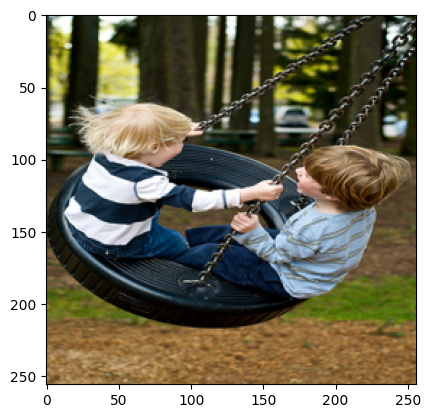

In [75]:
img = test_images[56].transpose(1,2,0)
evaluateCNN_RNN(img, cnn_rnn_encoder, cnn_rnn_decoder, word_map)

a little girl in a pink shirt is playing in the sand at the beach


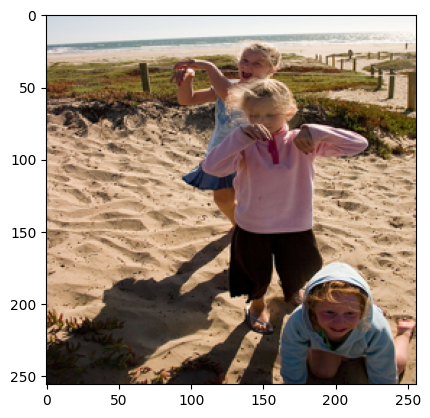

In [199]:
img = test_images[78].transpose(1,2,0)
evaluateCNN_RNN(img, cnn_rnn_encoder, cnn_rnn_decoder, word_map)

a dog with a tennis ball is flying over the green ball


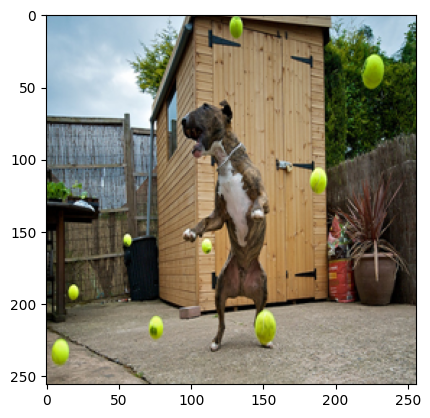

In [186]:
img = test_images[999].transpose(1,2,0)
evaluateCNN_RNN(img, cnn_rnn_encoder, cnn_rnn_decoder, word_map)

In [56]:
def getBleuScores(test_loader, encoder, decoder, word_map):
    """
    computes the bleu scores: 1,2,3, and 4 for a given set
    
    """
    encoder.eval()
    decoder.eval()

    hypotheses = []
    references = []

    with torch.no_grad():
        for i, (img, caption, caplen, allcaps) in enumerate(test_loader):
            img = img.to(device)
            caption = caption.to(device)
            caplen = caplen.to(device)

            image_features = encoder(img)
            scores, caps_sorted, decode_lengths, sort_ind = decoder(image_features, caption, caplen)

            # References
            allcaps = allcaps.to(device)
            sort_ind = sort_ind.to(device)
            allcaps = allcaps[sort_ind]
            for j in range(allcaps.shape[0]):
                img_caps = allcaps[j].tolist()
                img_captions = [
                    [w for w in c if w not in {word_map['<start>'], word_map['<pad>']}]
                    for c in img_caps
                ]  # remove <start> and pads
                references.append(img_captions)

            # Hypotheses
            _, preds = torch.max(scores, dim=2)
            preds = preds.tolist()
            temp_preds = []
            for j, p in enumerate(preds):
                temp_preds.append(preds[j][:decode_lengths[j]])  # remove pads
            preds = temp_preds
            hypotheses.extend(preds)

    bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(references, hypotheses)

    return bleu1, bleu2, bleu3, bleu4


In [57]:
bleu1, bleu2, bleu3, bleu4 = getBleuScores(dataloaders['test'], cnn_rnn_encoder, cnn_rnn_decoder, word_map)

In [58]:
print("Bleu-1, Bleu-2, Bleu-3, Bleu-4 scores are : ", bleu1 * 100, bleu2 * 100, bleu3 * 100, bleu4 *100)

Bleu-1, Bleu-2, Bleu-3, Bleu-4 scores are :  64.25044240330328 40.98586740024793 24.810865980902562 14.631833073170977


In [60]:
data_ = np.load("preprocessed/combined_loss_bleu4.npz")

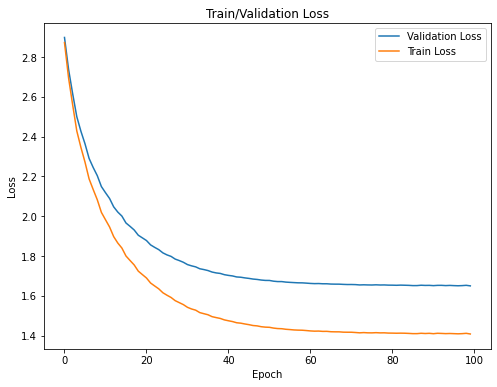

In [37]:
plt.figure(figsize=(8,6))

plt.plot(data_['val_loss'], label='Validation Loss')
plt.plot(data_['train_loss'], label='Train Loss')
# plt.plot(train_loss['Step'], train_loss['Value'], label='Train Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train/Validation Loss')
plt.legend()

plt.savefig('preprocessed/train_validation_loss_plot.png')

plt.show()

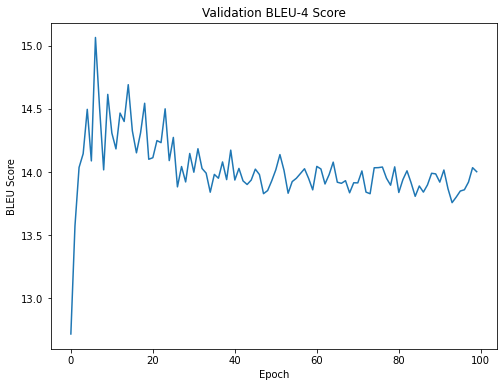

In [41]:

plt.figure(figsize=(8, 6))

plt.plot(data_['bleu4'] * 100)

plt.xlabel('Epoch')
plt.ylabel('BLEU Score')
plt.title('Validation BLEU-4 Score')

plt.savefig('preprocessed/bleu4_plot.png')

plt.show()

### BUILDING THE CNN-GPT

In [61]:
config = {
    "dataset_dir": "dataset",
    "glove_dir": "glove",
    "dataset_path": "dataset/text/Flickr8k.token.txt",

    "split_images": {
        "train": "dataset/text/Flickr_8k.trainImages.txt",
        "validation": "dataset/text/Flickr_8k.devImages.txt",
        "test": "dataset/text/Flickr_8k.testImages.txt",
        "inference": "dataset/text/Flickr_8k.inferenceImages.txt"
    },
    
    "split_save": {
        "train": "dataset/text/train.txt",
        "validation": "dataset/text/validation.txt",
        "test": "dataset/text/test.txt", 
        "inference": "dataset/text/inference.txt"
    },

    "word2idx_path": "dataset/word2idx.json",
    "embeddings": {
        "path": "dataset/embeddings.txt",
        "size": 100
    },

    "image_specs": {
        "image_dir": {
            "train": "dataset/images",
            "validation": "dataset/images",
            "test": "dataset/images",
            "inference": "dataset/images"
        },
        "img_feature_channels": 2048,
        "image_size": 256
    },

    "vocab_size": 7890,

    "PAD_token": "<pad>",
    "PAD_idx": 0,

    "START_idx": 1,
    "START_token": "<start>",

    "END_idx": 2,
    "END_token": "<end>",

    "UNK_idx": 3,
    "UNK_token": "<unk>",

    "max_len": 64,

    "use_gpu": True,
    "seed": 2021,

    "batch_size": {
        "train": 32,
        "eval": 32
    },

    "model_configuration": {
        "decoder_layers": 6,
        "d_model": 512,
        "ff_dim": 1024,
        "attention_heads": 16,
        "dropout": 0.5
    },

    "train_config": {
        "num_of_epochs": 100,
        "warmup_steps": 2811,
        "l2_penalty": 0.5,
        "learning_rate": 0.00005,
        "gradient_clipping": 2.0,
        "eval_period": 3
    },

    "bleu_weights": {
        "bleu-1": [1.0],
        "bleu-2": [0.5, 0.5],
        "bleu-3": [0.333, 0.333, 0.333],
        "bleu-4": [0.25, 0.25, 0.25, 0.25]
    },

    "checkpoint": {
        "load": False,
        "path": "checkpoints"
    }
}

In [62]:
def set_up_causal_mask(seq_len, device):
    """Defines the triangular mask used in transformers.

    This mask prevents decoder from attending the tokens after the current one.

    Arguments:
        seq_len (int): Maximum length of input sequence
        device: Device on which to map the created tensor mask
    Returns:
        mask (torch.Tensor): Created triangular mask
    """
    mask = (torch.triu(torch.ones(seq_len, seq_len)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0)).to(device)
    mask.requires_grad = False
    return mask


def log_gradient_norm(model, writer, step, mode, norm_type=2):
    """Writes model param's gradients norm to tensorboard"""
    total_norm = 0
    for p in model.parameters():
        if p.requires_grad:
            param_norm = p.grad.data.norm(norm_type)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** (1. / 2)
    writer.add_scalar(f"Gradient/{mode}", total_norm, step)


def save_checkpoint(encoder, decoder, optimizer, start_time, epoch):
    """Saves specified model checkpoint."""
    target_dir = os.path.join(config["checkpoint"]["path"], str(start_time))
    os.makedirs(target_dir, exist_ok=True)
    # Save model weights
    save_path_encoder = os.path.join(target_dir, f"encoder_{epoch}.pth")
    save_path_decoder = os.path.join(target_dir, f"decoder_{epoch}.pth")
    save_path_optimizer = os.path.join(target_dir, f"optimizer_{epoch}.pth")
    torch.save(encoder.state_dict(), save_path_encoder)
    torch.save(decoder.state_dict(), save_path_decoder)
    torch.save(optimizer.state_dict(), save_path_optimizer)
    print("Model saved.")
    
def save_best_model(encoder, decoder, optimizer):
    """Saves best model."""
    target_dir = os.path.join(config["checkpoint"]["path"], 'best_model')
    os.makedirs(target_dir, exist_ok=True)
    # Save model weights
    save_path_encoder = os.path.join(target_dir, "encoder.pth")
    save_path_decoder = os.path.join(target_dir, "decoder.pth")
    save_path_optimizer = os.path.join(target_dir, "optimizer.pth")
    torch.save(encoder.state_dict(), save_path_encoder)
    torch.save(decoder.state_dict(), save_path_decoder)
    torch.save(optimizer.state_dict(), save_path_optimizer)
    print("Best model saved.")

In [63]:
def greedy_decoding(model, img_features_batched, sos_id, eos_id, pad_id, idx2word, max_len, device):
    """Performs greedy decoding for the caption generation.
    At each iteration model predicts the next word in the caption given the previously
    generated words and image features. For the next word we always take the most probable one.
    Arguments:
        model (torch.nn.Module): Transformer Decoder model which generates prediction for the next word
        img_features_padded (torch.Tensor): Image features generated by CNN encoder
            Stacked along 0-th dimension for each image in the mini-batch
        sos_id (int): Id of <start> token in the vocabulary
        eos_id (int): Id of <end> token in the vocabulary
        pad_id (int): Id of <pad> token in the vocabulary
        idx2word (dict): Mapping from ordinal number of token (i.e. class number) to the string of word
        max_len (int): Maximum length of the caption
        device (torch.device): Device on which to port used tensors
    Returns:
        generated_captions (list of str): Captions generated for each image in the batch
    """
    batch_size = img_features_batched.size(0)

    # Define the initial state of decoder input
    x_words = torch.Tensor([sos_id] + [pad_id] * (max_len - 1)).to(device).long()
    x_words = x_words.repeat(batch_size, 1)
    padd_mask = torch.Tensor([True] * max_len).to(device).bool()
    padd_mask = padd_mask.repeat(batch_size, 1)

    # Is each image from the batch decoded
    is_decoded = [False] * batch_size
    generated_captions = []
    for _ in range(batch_size):
        generated_captions.append([])

    for i in range(max_len - 1):
        # Update the padding masks
        padd_mask[:, i] = False

        # Get the model prediction for the next word
        y_pred_prob = model(x_words, img_features_batched, padd_mask)
        # Extract the prediction from the specific (next word) position of the target sequence
        y_pred_prob = y_pred_prob[torch.arange(batch_size), [i] * batch_size].clone()
        # Extract the most probable word
        y_pred = y_pred_prob.argmax(-1)
        
        for batch_idx in range(batch_size):
            if is_decoded[batch_idx]:
                continue
            # Add the generated word to the caption
            generated_captions[batch_idx].append(idx2word[str(y_pred[batch_idx].item())])
            if y_pred[batch_idx] == eos_id:
                # Caption has been fully generated for this image
                is_decoded[batch_idx] = True
            
        if np.all(is_decoded):
            break

        if i < (max_len - 1):   # We haven't reached maximum number of decoding steps
            # Update the input tokens for the next iteration
            x_words[torch.arange(batch_size), [i+1] * batch_size] = y_pred.view(-1)

    # Complete the caption for images which haven't been fully decoded
    for batch_idx in range(batch_size):
        if not is_decoded[batch_idx]:
            generated_captions[batch_idx].append(idx2word[str(eos_id)])

    # Clean the EOS symbol
    for caption in generated_captions:
        caption.remove("<end>")

    return generated_captions

In [64]:
def preprocess_caption(caption):
    """Performs caption preprocessing"""
    punct_table = str.maketrans("", "", string.punctuation)
    # Extract separate tokens
    caption = caption.split()
    # Make tokens lowercase
    caption = [word.lower() for word in caption]
    # Remove punctuation
    caption = [word.translate(punct_table) for word in caption]
    # Remove trailing "'s" or "a"
    caption = [word for word in caption if len(word) > 1]
    # Remove tokens which contain number
    caption = [word for word in caption if word.isalpha()]
    return " ".join(caption)


def save_captions(image2caption, subset_imgs, save_path):
    """Saves captions for images which belong to subset to a file.
    Arguments:
        image2caption (dict): Mapping from image id to all
            captions of that image that occured in the dataset
        subset_imgs (list of str): List of image names which belong to subset
        save_path (str): Path to which to save extracted captions
    """
    captions = []
    for image_name in subset_imgs:
        image_id = os.path.splitext(image_name)[0]
        if image_id in image2caption:
            for caption in image2caption[image_id]:
                captions.append("{} {}\n".format(image_name, caption))

    # Save extracted captions
    with open(save_path, "w") as f:
        f.writelines(captions)


def split_dataset(image2caption, split_images_paths, save_paths):
    """Perfoms splitting of the dataset.
    Arguments:
        image2caption (dict): Mapping from image id to all
            captions of that image that occured in the dataset
        split_images_paths (list of str): Contains paths of files which contain
            names of images which belong to each subset in the split
        split_images_paths (list of str): Contains paths to which to save
            captions extracted for each image in specified subsets
    """
    for load_path, save_path in zip(split_images_paths, save_paths):
        # Load names of images which belong to current subset
        with open(load_path, "r") as f:
            subset_imgs = [fname.replace("\n", "") for fname in f.readlines()]
        # Save processed captions for those images in a separate file
        save_captions(image2caption, subset_imgs, save_path)


def extract_embeddings(config, vocab):
    """Extracts GloVe word embeddings for words in vocab.

    Arguments:
        config (object): Contains dataset & pipeline configuration info
    """
    np.random.seed(config["seed"])
    embeddings_config = config["embeddings"]
    save_path_emb = embeddings_config["path"]
    embedding_dim = embeddings_config["size"]

    punct_table = str.maketrans("", "", string.punctuation)

    # Used for finding the embedding vector for each token
    vectors = []
    new_vocab = {"<pad>": 0, "<start>": 1, "<end>": 2, "<unk>": 3}
    # Counter used for determining the mapping from word to index
    i = len(new_vocab)

    embedding_file_name = "glove.6B.{}d.txt".format(embedding_dim)
    embeddings_path = os.path.join(config["glove_dir"], embedding_file_name)
    with open(embeddings_path, "rb") as f:
        for line in f:
            line = line.decode().split()
            # Extract and pre-process the token
            word = line[0]
            word = word.strip().lower()
            # Remove punctuation
            word = word.translate(punct_table)
            if word in vocab and word not in new_vocab:
                # Save embedding only for words present in the vocab
                embedding_vec = np.array(line[1:], dtype="float")
                vectors += [embedding_vec]
                new_vocab[word] = i
                i += 1

    # Save vocabulary to a file
    with open(config["word2idx_path"], "w", encoding="utf8") as f:
        json.dump(new_vocab, f)

    vectors = np.array(vectors)
    # Embedding vector for tokens used for padding the input sequence
    pad_embedding = np.zeros((embedding_dim,))
    # Embedding vector for start of the sequence
    sos_embedding = np.random.normal(size=(embedding_dim,))
    # Embedding vector for end of the sequence
    eos_embedding = np.random.normal(size=(embedding_dim,))
    # Embedding vector for unknown token
    unk_embedding =  np.random.normal(size=(embedding_dim,))

    # Sanity check: we can't have duplicate embeddings
    assert not np.allclose(sos_embedding, eos_embedding), "SOS and EOS embeddings are too close!"
    for emb_vec in vectors:
        assert not np.allclose(sos_embedding, emb_vec), "SOS embedding is too close to other embedding!"
        assert not np.allclose(eos_embedding, emb_vec), "EOS embedding is too close to other embedding!"

    vectors = np.vstack([pad_embedding, sos_embedding, eos_embedding, unk_embedding, vectors])
    # Save extracted embeddings
    np.savetxt(save_path_emb, vectors)

    print("\nExtracted GloVe embeddings for all tokens in the training set.") 
    print("Embedding vectors size:", embedding_dim)
    print("Vocab size:", len(new_vocab))


def create_vocab(image2caption):
    """Creates a vocabulary of tokens in the dataset corpus.
    
    Arguments:
        image2caption (dict): Mapping from image id to all
            captions of that image that occured in the dataset
        save_path (str): Path to which to save genererated vocabulary
    """
    # Vocabulary dictionary
    word2idx = {"<pad>": 0, "<start>": 1, "<end>": 2, "<unk>": 3}
    # All possible words in the token
    words = set()
    # Extract all tokens from the image captions
    for captions in image2caption.values():
        current_words = [word for caption in captions for word in caption.split()]
        words.update(current_words)

    starting_len = len(word2idx)
    words = list(words)
    word2idx.update({word: (idx + starting_len) for idx, word in enumerate(words)})

    return word2idx


def clean_captions(id2annotation):
    """Cleans the loaded image captions.
    
    Makes tokens lowercase. Removes punctuation. Removes some stop words.

    Arguments:
        image2caption (dict): Mapping from image id to all
            captions of that image that occured in the dataset
    Returns:
        image2caption_clean (dict): Mapping from image id to
            cleaned captions of that image
    """
    image2caption_clean = id2annotation.copy()
    for image_id, captions in id2annotation.items():
        for i in range(len(captions)):
            caption = captions[i]
            # Preprocess caption
            clean_caption = preprocess_caption(caption)
            # Save the cleaned caption
            image2caption_clean[image_id][i] =  clean_caption

    return image2caption_clean


def load_captions(data):
    """Processes the loaded image captions.

    Image captions are saved in the following format:
        image_id[SPACE]Caption
    
    Arguments:
        data (str): Loaded image captions from .txt file
    Returns:
        image2desc (dict): Mapping from image id to all
            captions of that image that occured in the dataset
        train_images (list of str): Containes names of images in train set
    """
    image2caption = dict()
    for sample in data.split("\n"):
        tokens = sample.split()
        if len(sample) < 2:
            # Image has no description: Invalid data row
            continue
        # First token is image id, remaining ones correspond to the caption
        image_name, image_caption = tokens[0], tokens[1:]

        image_id = image_name.split(".")[0]
        # Recreate the description
        image_caption = " ".join(image_caption)
        
        if image_id not in image2caption:
            image2caption[image_id] = list()
        # Save the description
        image2caption[image_id].append(image_caption)

    return image2caption

In [66]:
# Load and clean the loaded captions
dataset_path = config["dataset_path"]
with open(dataset_path, "r") as f:
    data = f.read()

image2caption = load_captions(data)
image2caption = clean_captions(image2caption)

# Create and save dataset corpus vocabulary
vocab = create_vocab(image2caption)
# Extract GloVe embeddings for tokens present in the training set vocab
extract_embeddings(config, vocab)

# Save info regarding the dataset split elements
split_images_paths = list(config["split_images"].values())
split_save_paths = list(config["split_save"].values())
split_dataset(image2caption, split_images_paths, split_save_paths)


Extracted GloVe embeddings for all tokens in the training set.
Embedding vectors size: 100
Vocab size: 7890


In [151]:
class Flickr8KDataset(Dataset):
    """"Represents dataloader for the Flickr8k dataset.

    Data is stored in following format:
        image_name: associated caption
    Each image has maximum 5 different captions.
    """

    def __init__(self, config, path, phase="train"):
        """Initializes the module.
        
        Arguments:
            config (object): Contains dataset configuration
            path (str): Location where image captions are stored
        """
        with open(path, "r") as f:
            self._data = [line.replace("\n", "") for line in f.readlines()]

#         self._training = training
        self._phase = phase

        # Create inference data
        self._inference_captions = self._group_captions(self._data)

        # Load the vocabulary mappings
        with open(config["word2idx_path"], "r", encoding="utf8") as f:
            self._word2idx = json.load(f)
        self._idx2word = {str(idx): word for word, idx in self._word2idx.items()}

        # Auxiliary token indices
        self._start_idx = config["START_idx"]
        self._end_idx = config["END_idx"]
        self._pad_idx = config["PAD_idx"]
        self._UNK_idx = config["UNK_idx"]
        # Auxiliary token marks
        self._START_token = config["START_token"]
        self._END_token = config["END_token"]
        self._PAD_token = config["PAD_token"]
        self._UNK_token = config["UNK_token"]

        self._max_len = config["max_len"]

        # Transformation to apply to each image
        self._image_specs = config["image_specs"]
        self._image_transform = self._construct_image_transform(self._image_specs["image_size"])

        # Create paths to image files belonging to the subset
#         subset = "train" if training else "validation"
        self.image_dir = self._image_specs["image_dir"][phase]

        # Create (X, Y) pairs
        self._data = self._create_input_label_mappings(self._data)

        # self._dataset_size = len(self._data)
        self._dataset_size = len(self._data) if self._phase!='test' else 0

    def _construct_image_transform(self, image_size):
        """Constructs the image preprocessing transform object.

        Arguments:
            image_size (int): Size of the result image
        """
        # ImageNet normalization statistics
        normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
        preprocessing = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            normalize,
        ])

        return preprocessing

    def _load_and_process_images(self, image_dir, image_names):
        """Loades dataset images and adapts them for the CNN.

        Arguments:
            image_dir (str): Directory where images are stored
            image_names (list of str): Names of image files in the dataset
        Returns:
            images_processed (dict): "ImageNet-adapted" versions of loaded images
                key: image name, dict: torch.Tensor of loaded and processed image
        """
        image_paths = [os.path.join(image_dir, fname) for fname in image_names]
        # Load images
        images_raw = [Image.open(path) for path in image_paths]
        # Adapt the images to CNN trained on ImageNet { PIL -> Tensor }
        image_tensors = [self._image_transform(img) for img in images_raw]

        images_processed = {img_name: img_tensor for img_name, img_tensor in zip(image_names, image_tensors)}
        return images_processed

    def _group_captions(self, data):
        """Groups captions which correspond to the same image.

        Main usage: Calculating BLEU score

        Arguments:
            data (list of str): Each element contains image name and corresponding caption
        Returns:
            grouped_captions (dict): Key - image name, Value - list of captions associated
                with that picture
        """
        grouped_captions = {}

        for line in data:
            caption_data = line.split()
            img_name, img_caption = caption_data[0].split("#")[0], caption_data[1:]
            if img_name not in grouped_captions:
                # We came across the first caption for this particular image
                grouped_captions[img_name] = []

            grouped_captions[img_name].append(img_caption)

        return grouped_captions

    def _create_input_label_mappings(self, data):
        """Creates (image, description) pairs.

        Arguments:
            data (list of str): Each element consists out of image file name and appropriate caption
                Elements are organized in the following format: 'image_name[SPACE]caption'
        Returns:
            processed_data (list of tuples): Each tuple is organized in following format: (image_name, caption)
        """
        processed_data = []
        for line in data:
            tokens = line.split()
            # Separate image name from the label tokens
            img_name, caption_words = tokens[0].split("#")[0], tokens[1:]
            # Construct (X, Y) pair
            pair = (img_name, caption_words)
            processed_data.append(pair)

        return processed_data

    def _load_and_prepare_image(self, image_name):
        """Performs image preprocessing.

        Images need to be prepared for the ResNet encoder.
        Arguments:
            image_name (str): Name of the image file located in the subset directory
        """
        image_path = os.path.join(self.image_dir, image_name)
        img_pil = Image.open(image_path).convert("RGB")
        image_tensor = self._image_transform(img_pil)
        return image_tensor

    def inference_batch(self, batch_size):
        """Creates a mini batch dataloader for inference.

        During inference we generate caption from scratch and in each iteration
        we feed words generated previously by the model (i.e. no teacher forcing).
        We only need input image as well as the target caption.
        """
        caption_data_items = list(self._inference_captions.items())
        # random.shuffle(caption_data_items)

        num_batches = len(caption_data_items) // batch_size
        for idx in range(num_batches):
            caption_samples = caption_data_items[idx * batch_size: (idx + 1) * batch_size]
            batch_imgs = []
            batch_captions = []

            # Increase index for the next batch
            idx += batch_size

            # Create a mini batch data
            for image_name, captions in caption_samples:
                batch_captions.append(captions)
                batch_imgs.append(self._load_and_prepare_image(image_name))

            # Batch image tensors
            batch_imgs = torch.stack(batch_imgs, dim=0)
            # if batch_size == 1:
            #     batch_imgs = batch_imgs.unsqueeze(0)

            yield batch_imgs, batch_captions

    def __len__(self):
        return self._dataset_size

    def __getitem__(self, index):
        # Extract the caption data
        image_id, tokens = self._data[index]

        # Load and preprocess image
        image_tensor = self._load_and_prepare_image(image_id)

        # Pad the token and label sequences
        tokens = tokens[:self._max_len]

        tokens = [token.strip().lower() for token in tokens]
        tokens = [self._START_token] + tokens + [self._END_token]
        # Extract input and target output
        input_tokens = tokens[:-1].copy()
        tgt_tokens = tokens[1:].copy()

        # Number of words in the input token
        sample_size = len(input_tokens)
        padding_size = self._max_len - sample_size

        if padding_size > 0:
            padding_vec = [self._PAD_token for _ in range(padding_size)]
            input_tokens += padding_vec.copy()
            tgt_tokens += padding_vec.copy()

        # Apply the vocabulary mapping to the input tokens
        input_tokens = [self._word2idx.get(token, self._UNK_idx) for token in input_tokens]
        tgt_tokens = [self._word2idx.get(token, self._UNK_idx) for token in tgt_tokens]

        input_tokens = torch.Tensor(input_tokens).long()
        tgt_tokens = torch.Tensor(tgt_tokens).long()

        # Index from which to extract the model prediction
        # Define the padding masks
        tgt_padding_mask = torch.ones([self._max_len, ])
        tgt_padding_mask[:sample_size] = 0.0
        tgt_padding_mask = tgt_padding_mask.bool()

        return image_tensor, input_tokens, tgt_tokens, tgt_padding_mask

In [68]:
class EncoderCNN(nn.Module):

    def __init__(self):
        super(EncoderCNN, self).__init__()
        encoder = torchvision.models.resnet101(pretrained=True)
        self.resnet = nn.Sequential(*(list(encoder.children())[:-2]))
        self.fine_tune()

    def fine_tune(self, fine_tune=False):
        for p in self.resnet.parameters():
            p.requires_grad = fine_tune

    def forward(self, images):
        #images: (b, 3, 254, 254)
        encoded_image = self.resnet(images)
        img_features = encoded_image.view(encoded_image.size(0), encoded_image.size(1), -1)
        img_features = img_features.permute(0, 2, 1)
        # img_features = img_features.detach()
        return img_features

In [69]:
class ResidualBlock(nn.Module):
    """Represents 1D version of the residual block: https://arxiv.org/abs/1512.03385"""

    def __init__(self, input_dim):
        """Initializes the module."""
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.LeakyReLU(),
            nn.Linear(input_dim, input_dim),
        )

    def forward(self, x):
        """Performs forward pass of the module."""
        skip_connection = x
        x = self.block(x)
        x = skip_connection + x
        return x

In [70]:
class Normalize(nn.Module):
    def __init__(self, eps=1e-5):
        super(Normalize, self).__init__()
        self.register_buffer("eps", torch.Tensor([eps]))

    def forward(self, x, dim=-1):
        norm = x.norm(2, dim=dim).unsqueeze(-1)
        x = self.eps * (x / norm)
        return x

In [71]:
class PositionalEncodings(nn.Module):
    """Attention is All You Need positional encoding layer"""

    def __init__(self, seq_len, d_model, p_dropout):
        """Initializes the layer."""
        super(PositionalEncodings, self).__init__()
        token_positions = torch.arange(start=0, end=seq_len).view(-1, 1)
        dim_positions = torch.arange(start=0, end=d_model).view(1, -1)
        angles = token_positions / (10000 ** ((2 * dim_positions) / d_model))

        encodings = torch.zeros(1, seq_len, d_model)
        encodings[0, :, ::2] = torch.cos(angles[:, ::2])
        encodings[0, :, 1::2] = torch.sin(angles[:, 1::2])
        encodings.requires_grad = False
        self.register_buffer("positional_encodings", encodings)

        self.dropout = nn.Dropout(p_dropout)

    def forward(self, x):
        """Performs forward pass of the module."""
        x = x + self.positional_encodings
        x = self.dropout(x)
        return x

In [87]:
class CaptionDecoder(nn.Module):
    """Decoder for image captions.

    Generates prediction for next caption word given the prviously
    generated word and image features extracted from CNN.    
    """

    def __init__(self, config):
        """Initializes the model."""
        super(CaptionDecoder, self).__init__()
        model_config = config["model_configuration"]
        decoder_layers = model_config["decoder_layers"]
        attention_heads = model_config["attention_heads"]
        d_model = model_config["d_model"]
        ff_dim = model_config["ff_dim"]
        dropout = model_config["dropout"]

        embedding_dim = config["embeddings"]["size"]
        vocab_size = config["vocab_size"]
        img_feature_channels = config["image_specs"]["img_feature_channels"]

        # Load pretrained word embeddings
        word_embeddings = torch.Tensor(np.loadtxt(config["embeddings"]["path"]))
        self.embedding_layer = nn.Embedding.from_pretrained(
            word_embeddings,
            freeze=True,
            padding_idx=config["PAD_idx"]
        )

        self.entry_mapping_words = nn.Linear(embedding_dim, d_model)
        self.entry_mapping_img = nn.Linear(img_feature_channels, d_model)

        self.res_block = ResidualBlock(d_model)

        self.positional_encodings = PositionalEncodings(config["max_len"], d_model, dropout)
        transformer_decoder_layer = TransformerDecoderLayer(
            d_model=d_model,
            nhead=attention_heads,
            dim_feedforward=ff_dim,
            dropout=dropout
        )
        self.decoder = TransformerDecoder(transformer_decoder_layer, decoder_layers)
        self.classifier = nn.Linear(d_model, vocab_size)

    def forward(self, x, image_features, tgt_padding_mask=None, tgt_mask=None):
        """Performs forward pass of the module."""
        # Adapt the dimensionality of the features for image patches
        image_features = self.entry_mapping_img(image_features)
        image_features = image_features.permute(1, 0, 2)
        image_features = F.leaky_relu(image_features)

        # Entry mapping for word tokens
        x = self.embedding_layer(x)
        x = self.entry_mapping_words(x)
        x = F.leaky_relu(x)

        x = self.res_block(x)
        x = F.leaky_relu(x)

        x = self.positional_encodings(x)

        # Get output from the decoder
        x = x.permute(1, 0, 2)
        x = self.decoder(
            tgt=x,
            memory=image_features,
            tgt_key_padding_mask=tgt_padding_mask,
            tgt_mask=tgt_mask
        )
        x = x.permute(1, 0, 2)

        x = self.classifier(x)
        return x

In [78]:
def evaluateCNN_GPT(subset, encoder, decoder, config, device):
    """Evaluates (BLEU score) caption generation model on a given subset.

    Arguments:
        subset (Flickr8KDataset): Train/Val/Test subset
        encoder (nn.Module): CNN which generates image features
        decoder (nn.Module): Transformer Decoder which generates captions for images
        config (object): Contains configuration for the evaluation pipeline
        device (torch.device): Device on which to port used tensors
    Returns:
        bleu (float): BLEU-{1:4} scores performance metric on the entire subset - corpus bleu
    """
    batch_size = config["batch_size"]["eval"]
    max_len = config["max_len"]
    bleu_w = config["bleu_weights"]

    encoder.eval()
    decoder.eval()

    # Mapping from vocab index to string representation
    idx2word = subset._idx2word
    # Ids for special tokens
    sos_id = subset._start_idx
    eos_id = subset._end_idx
    pad_id = subset._pad_idx

    references_total = []
    predictions_total = []

    print("Evaluating model.")
    for x_img, y_caption in subset.inference_batch(batch_size):
        x_img = x_img.to(device)

        # Extract image features
        img_features = encoder(x_img)

        # Get the caption prediction for each image in the mini-batch
        predictions = greedy_decoding(decoder, img_features, sos_id, eos_id, pad_id, idx2word, max_len, device)
        references_total += y_caption
        predictions_total += predictions

    # Evaluate BLEU score of the generated captions
    bleu_1 = corpus_bleu(references_total, predictions_total, weights=bleu_w["bleu-1"]) * 100
    bleu_2 = corpus_bleu(references_total, predictions_total, weights=bleu_w["bleu-2"]) * 100
    bleu_3 = corpus_bleu(references_total, predictions_total, weights=bleu_w["bleu-3"]) * 100
    bleu_4 = corpus_bleu(references_total, predictions_total, weights=bleu_w["bleu-4"]) * 100
    bleu = [bleu_1, bleu_2, bleu_3, bleu_4]

    # acc = topk_accuracy(references_total, predictions_total, 3)
    return bleu

In [80]:
def train(config, writer, device):
    """Performs the training of the model.

    Arguments:
        config (object): Contains configuration of the pipeline
        writer: tensorboardX writer object
        device: device on which to map the model and data
    """
    torch.manual_seed(config["seed"])
    np.random.seed(config["seed"])

   # Define dataloader hyper-parameters
    train_hyperparams = {
        "batch_size": config["batch_size"]["train"],
        "shuffle": True,
        "num_workers": 1,
        "drop_last": True
    }

    # Create dataloaders
    train_set = Flickr8KDataset(config, config["split_save"]["train"], phase='train')
    valid_set = Flickr8KDataset(config, config["split_save"]["validation"], phase='validation')
    datasets = {"Train": train_set, "Validation": valid_set}

    train_loader = DataLoader(train_set, **train_hyperparams)
    validation_loader = DataLoader(valid_set, **train_hyperparams)
    dataloader = {"Train": train_loader, "Validation": validation_loader}

    # Set up encoder
    encoder = EncoderCNN()
    encoder = encoder.to(device)
    
    # Set up the decoder
    decoder = CaptionDecoder(config)
    decoder = decoder.to(device)
    
    if config["checkpoint"]["load"]:
        checkpoint_path = config["checkpoint"]["path"]
        decoder.load_state_dict(torch.load(checkpoint_path))

    # Set up causal mask for transformer decoder
    causal_mask = set_up_causal_mask(config["max_len"], device)

    # Load training configuration
    train_config = config["train_config"]

    # Prepare the model optimizer
    optimizer = torch.optim.AdamW(
        decoder.parameters(),
        lr=train_config["learning_rate"],
        weight_decay=train_config["l2_penalty"]
    )
    # Loss function
    loss_fcn = nn.CrossEntropyLoss(label_smoothing=0.1)

    start_time = time.strftime("%b-%d_%H-%M-%S")
    train_step = 0
    best_score = 0

    for epoch in range(train_config["num_of_epochs"]):
        for phase in ['Train', 'Validation']:
            print(f"Epoch: {epoch}, Phase: {phase}")
            if phase == 'Train':
                encoder.train()
                decoder.train()
            else:
                encoder.eval()
                decoder.eval()
                
            running_loss = 0.0
            total_samples = 0
        
            for x_img, x_words, y, tgt_padding_mask in dataloader[phase]:
                optimizer.zero_grad()
                train_step += 1
                total_samples += len(x_img)

                # Move the used tensors to defined device
                x_img, x_words = x_img.to(device), x_words.to(device)
                y = y.to(device)
                tgt_padding_mask = tgt_padding_mask.to(device)

                # Extract image features
                with torch.set_grad_enabled(phase == 'Train'):
                    img_features = encoder(x_img)
                    # Get the prediction of the decoder
                    y_pred = decoder(x_words, img_features, tgt_padding_mask, causal_mask)
                    tgt_padding_mask = torch.logical_not(tgt_padding_mask)
                    y_pred = y_pred[tgt_padding_mask]

                    y = y[tgt_padding_mask]

                    # Calculate the loss
                    loss = loss_fcn(y_pred, y.long())

                    if(phase == 'Train'):
                        # Update model weights
                        loss.backward()
                        log_gradient_norm(decoder, writer, train_step, "Before")
                        torch.nn.utils.clip_grad_norm_(decoder.parameters(), train_config["gradient_clipping"])
                        log_gradient_norm(decoder, writer, train_step, "After")
                        optimizer.step()

                    running_loss += loss.item() * x_img.size(0)

            epoch_loss = running_loss / total_samples
            bleu_scores = evaluateCNN_GPT(datasets[phase], encoder, decoder, config, device)
            epoch_score = bleu_scores[3]

            writer.add_scalar(f"{phase}/Loss", epoch_loss, epoch)
            for i, t_b in enumerate(bleu_scores):
                writer.add_scalar(f"{phase}/BLEU-{i+1}", t_b, epoch)
            
            print(f"Loss: {epoch_loss}, Score: {epoch_score}")
            
            if phase == 'Validation':
                if epoch_score > best_score:
                    best_score=epoch_score
                    print(f"Best Score Found {best_score}")
                    # Save the best model
                    save_best_model(encoder, decoder, optimizer)
                    
                # Save the model and optimizer state
                save_checkpoint(encoder, decoder, optimizer, start_time, epoch)
            
        print()

In [ ]:
writer = SummaryWriter()
use_gpu = config["use_gpu"] and torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")
device

In [81]:
# Test model performance
def test(encoder, decoder, config, device, writer):
    test_set = Flickr8KDataset(config, config["split_save"]["test"], phase='test')
    with torch.no_grad():
        encoder.eval()
        decoder.eval()

        # Evaluate model performance on subsets
        test_bleu = evaluateCNN_GPT(test_set, encoder, decoder, config, device)
        print(test_bleu)

        # Log the evaluated BLEU score
        for i, t_b in enumerate(test_bleu):
            writer.add_scalar("Test/BLEU", t_b, i+1)        

In [96]:
encoder_path = 'cnn_gpt_encoder_99.pth'
decoder_path = 'cnn_gpt_decoder_99.pth'

# Set up encoder
cnn_gpt_encoder = EncoderCNN()
cnn_gpt_encoder = cnn_gpt_encoder.to(device)
cnn_gpt_encoder.load_state_dict(torch.load(encoder_path, map_location=torch.device('cpu')))

# Set up the decoder
cnn_gpt_decoder = CaptionDecoder(config)
cnn_gpt_decoder = cnn_gpt_decoder.to(device)
cnn_gpt_decoder.load_state_dict(torch.load(decoder_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
test(cnn_gpt_encoder, cnn_gpt_decoder, config, device, writer)

In [ ]:
writer.flush()
writer.close()

In [370]:
def inference():
    batch_size = 1
    max_len = config["max_len"]

    inference_data = Flickr8KDataset(config, config["split_save"]["inference"], phase='inference')
    
    # Mapping from vocab index to string representation
    idx2word = inference_data._idx2word
    # Ids for special tokens
    sos_id = inference_data._start_idx
    eos_id = inference_data._end_idx
    pad_id = inference_data._pad_idx

    predictions = []
    print("Inference.")
    for x_img, y_caption in inference_data.inference_batch(batch_size):
        x_img = x_img.to(device)

        # Extract image features
        img_features = cnn_gpt_encoder(x_img)

        # Get the caption prediction for each image in the mini-batch
        prediction = greedy_decoding(cnn_gpt_decoder, img_features, sos_id, eos_id, pad_id, idx2word, max_len, device)
        # print(prediction)
        predictions += prediction

    return predictions
        

Inference.


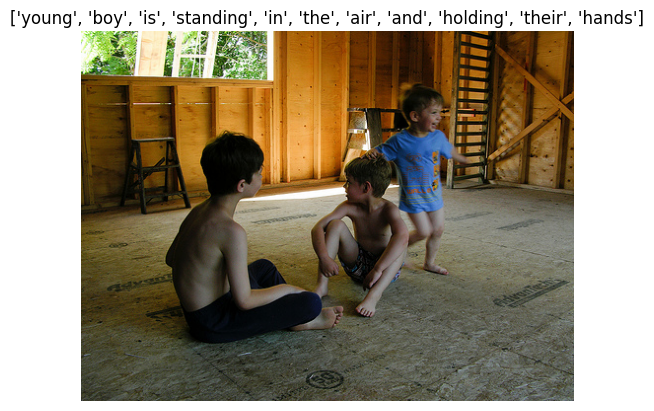

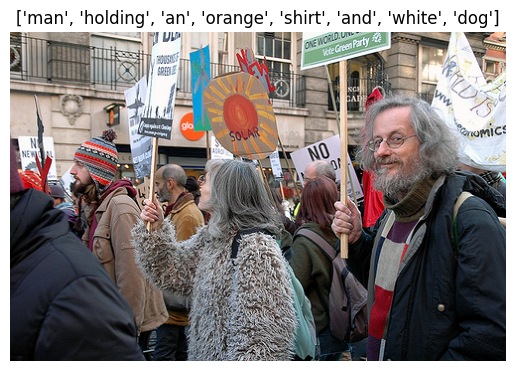

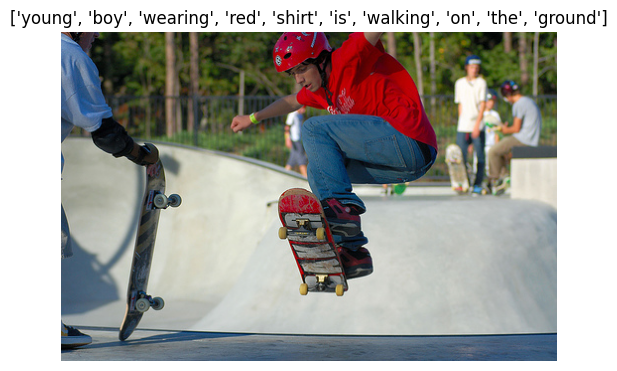

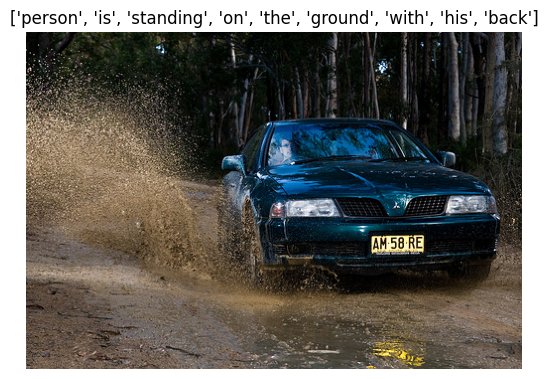

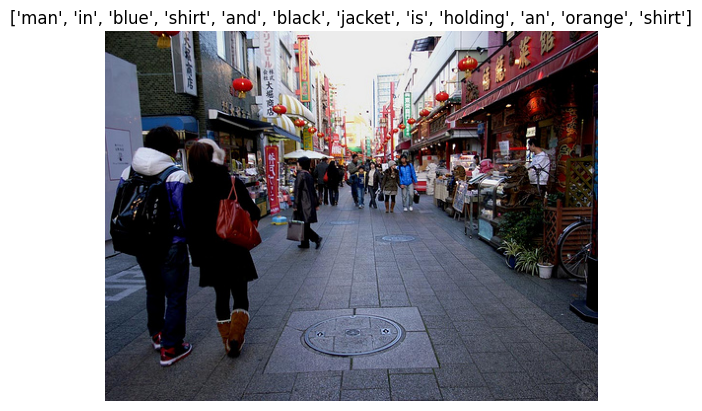

In [373]:
predictions = inference()

img_path = config['split_images']['inference']
with open(img_path, "r") as f:
    subset_imgs = [fname.replace("\n", "") for fname in f.readlines()]

for i, caption in enumerate(predictions):
    plt.imshow(Image.open(config['dataset_dir']+'/images/'+subset_imgs[i]))
    plt.title(caption)
    plt.axis('off')
    plt.show()

##### Visualizing some predictions generated by both models

In [182]:
test_set = Flickr8KDataset(config, config["split_save"]["test"], phase='test')

In [406]:
max_len = config["max_len"]

# inference_data = Flickr8KDataset(config, config["split_save"]["inference"], phase='inference')
inference_data = Flickr8KDataset(config, config["split_save"]["test"], phase='test')
# Mapping from vocab index to string representation
idx2word = inference_data._idx2word
# Ids for special tokens
sos_id = inference_data._start_idx
eos_id = inference_data._end_idx
pad_id = inference_data._pad_idx

In [407]:
def prepareImage(image):
    image = image.transpose(1,2,0)
    img = image / 255.
    img = img.transpose(2, 0, 1)
    img = torch.FloatTensor(img).to(device)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([normalize])
    image = transform(img)
    image = image.unsqueeze(0) #(3, 256, 256) => (1, 3, 256, 256)
    return image


def decodeRNN(processed_image, encoder, decoder, word_map):

    """
    processed_image: Output from the prepareImage() function
    """
    sampled = []
    rev_word_map = {v:k for k,v in word_map.items()}
    image_features = encoder(processed_image)
    pred = torch.LongTensor([[word_map['<start>']]]).to(device) #(1,1)
    h,c = decoder.init_hidden_states(1)

    for timestep in range((max_len)):
        embeddings = decoder.embedding(pred).squeeze(1) # (1, 512)
        lstm_input = torch.cat([embeddings, image_features],  dim=-1) # cat (1, 512) and (1, 512) => (1, 1024)
        h, c = decoder.lstm(lstm_input, (h, c))
        preds = decoder.fc(h)
        _, pred = preds.max(1)
        sampled.append(pred)

        if pred == word_map['<end>']:
            break

    generated_words = [rev_word_map[sampled[i].item()] for i in range(len(sampled))]
    filtered_words = " ".join([word for word in generated_words if word != '<end>'])
    return filtered_words



def decodeGPT(model, img_features_batched, sos_id, eos_id, pad_id, idx2word, max_len, device):
    """Performs greedy decoding for the caption generation.
    At each iteration model predicts the next word in the caption given the previously
    generated words and image features. For the next word we always take the most probable one.
    Arguments:
        model (torch.nn.Module): Transformer Decoder model which generates prediction for the next word
        img_features_padded (torch.Tensor): Image features generated by CNN encoder
            Stacked along 0-th dimension for each image in the mini-batch
        sos_id (int): Id of <start> token in the vocabulary
        eos_id (int): Id of <end> token in the vocabulary
        pad_id (int): Id of <pad> token in the vocabulary
        idx2word (dict): Mapping from ordinal number of token (i.e. class number) to the string of word
        max_len (int): Maximum length of the caption
        device (torch.device): Device on which to port used tensors
    Returns:
        generated_captions (list of str): Captions generated for each image in the batch
    """
    batch_size = img_features_batched.size(0)

    # Define the initial state of decoder input
    x_words = torch.Tensor([sos_id] + [pad_id] * (max_len - 1)).to(device).long()
    x_words = x_words.repeat(batch_size, 1)
    padd_mask = torch.Tensor([True] * max_len).to(device).bool()
    padd_mask = padd_mask.repeat(batch_size, 1)

    # Is each image from the batch decoded
    is_decoded = [False] * batch_size
    generated_captions = []
    for _ in range(batch_size):
        generated_captions.append([])

    for i in range(max_len - 1):
        # Update the padding masks
        padd_mask[:, i] = False

        # Get the model prediction for the next word
        y_pred_prob = model(x_words, img_features_batched, padd_mask)
        # Extract the prediction from the specific (next word) position of the target sequence
        y_pred_prob = y_pred_prob[torch.arange(batch_size), [i] * batch_size].clone()
        # Extract the most probable word
        y_pred = y_pred_prob.argmax(-1)
        
        for batch_idx in range(batch_size):
            if is_decoded[batch_idx]:
                continue
            # Add the generated word to the caption
            generated_captions[batch_idx].append(idx2word[str(y_pred[batch_idx].item())])
            if y_pred[batch_idx] == eos_id:
                # Caption has been fully generated for this image
                is_decoded[batch_idx] = True
            
        if np.all(is_decoded):
            break

        if i < (max_len - 1):   # We haven't reached maximum number of decoding steps
            # Update the input tokens for the next iteration
            x_words[torch.arange(batch_size), [i+1] * batch_size] = y_pred.view(-1)

    # Complete the caption for images which haven't been fully decoded
    for batch_idx in range(batch_size):
        if not is_decoded[batch_idx]:
            generated_captions[batch_idx].append(idx2word[str(eos_id)])

    # Clean the EOS symbol
    for caption in generated_captions:
        caption.remove("<end>")

    generated_captions = ' '.join(inner for outer in generated_captions for inner in outer)

    return generated_captions

In [597]:
random_number = random.randint(1, 1000)
sampl_image = test_images[random_number]
# x_img, y_caption = list(inference_data.inference_batch(1))[random_number]
preparedimage = prepareImage(sampl_image)
# preparedimage = x_img

img_features_rnn = cnn_rnn_encoder(preparedimage)
img_features_gpt = cnn_gpt_encoder(preparedimage)
prediction_gpt = decodeGPT(cnn_gpt_decoder, img_features_gpt, sos_id, eos_id, pad_id, idx2word, max_len, device)
prediction_rnn = decodeRNN(preparedimage, cnn_rnn_encoder, cnn_rnn_decoder, word_map)

# x_img = x_img.squeeze(0)
# x_img = x_img.numpy().transpose(1,2,0)
sampl_image = sampl_image.transpose(1,2,0)

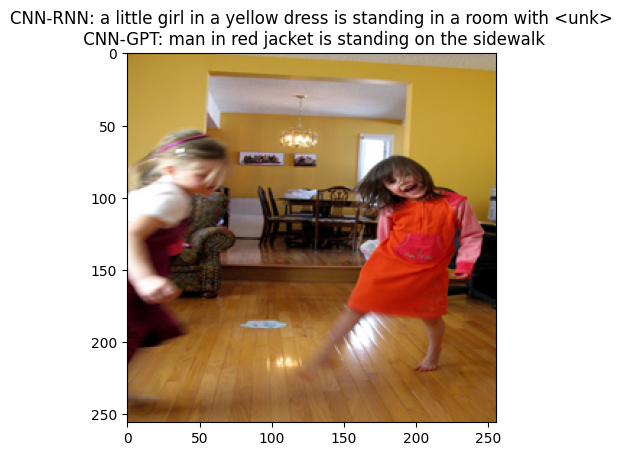

In [598]:

plt.figure()

# Add a title with the defined strings
plt.title(f"CNN-RNN: {prediction_rnn}\n CNN-GPT: {prediction_gpt}")
plt.imshow(sampl_image)

# plt.savefig(f'generatedCaptions/{random_number}.png')

# Show the figure
plt.show()

In [606]:
"""
Combines all generated images and captions inside a single image

"""

folder_path = "/Users/jacobidoko/Desktop/ENEL final project/final_dataset/generatedCaptions"
images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Ensure you have 12 images
if len(images) != 12:
    print("Error: Folder needs to contain 12 images.")
    exit()

images.sort()  # Ensure images are in a consistent order

# Get dimensions of the first image (assuming all images have the same size)
img = Image.open(images[0])
width, height = img.size

# Create a new blank image with adjusted dimensions for a 4x3 grid
combined_width = width * 3  # 3 columns
combined_height = height * 4  # 4 rows
combined_image = Image.new('RGB', (combined_width, combined_height))

# Paste each image into the combined image using a 4x3 layout
row = 0
column = 0
for image in images:
    with Image.open(image) as img:
        combined_image.paste(img, (column * width, row * height))
        column += 1
        if column == 3:  # Move to the next row after every 3 columns
            column = 0
            row += 1

# Save the combined image
combined_image.save("combined_images.jpg")
print("Images combined successfully!")


Images combined successfully!
